# Table of Contents
1. [Introduction](#1-introduction)
2. [Reading data](#2-reading-data)
    - 2.1 [File Structure](#21-file-structure)
    - 2.2 [Raw Data](#22-raw-data)
3. [Integrate Data](#3-integrate-data)
    - 3.1 [Determine Degree of Symmetry](#31-determine-degree-of-symmetry-azimuthalpolar-integration)
    - 3.2 [Radial integration](#32-radial-integration)
    - 3.3 [Reshape](#33-reshape)
        - 3.3.1 [Plot Intensity on sample geometry](#331-plotting-intensity-on-sample-geometry-all-images)
4. [Curve Fitting](#4-curve-fitting)
    - 4.1 [Removing Background Noise](#41-removing-background-noise)
    - 4.1.1 [Plot Data Without Background Noise](#42-plot-data-without-background-noise)
    - 4.2 [Fit Noise Free Data To Some Function](#43-fit-nosie-free-data-to-some-function)
    - 4.3 [Plot Fitted Data](#44-plot-fitted-data)

# 1 Introduction
Some information about SAXS/WAXS and the experiments.

# 2 Reading data


## 2.1 File structure
The data we have at FORMAX is gathered by two sensors.

    lambda, which measures the Wide Angle X-ray Scattering (WAXS)
    eiger, which measures the Small Angle X-ray Scattering (SAXS)

The sensors measure the number of photons hitting each pixel for a given exposure time, This is the raw data.

For each scan, there are three files that are stored as HDF5 files in the raw/ folder, which houses this data:

    scan-xxxx.h5: The master file for the scan, containing useful metadata for the scan.
    scan-xxxx_lambda.h5: The data from the WAXS scan.
    scan-xxxx_eiger.h5: The data from the SAXS scan.

Let us load the data first. We will also create a function that gives us the appropriate file path to use. 

In [21]:
import h5py
import os
import hdf5plugin
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors as mcolors
from matplotlib.ticker import FuncFormatter
from scipy import fft
from scipy import signal
from scipy.signal import find_peaks, savgol_filter
from scipy.stats import norm
from scipy.optimize import curve_fit

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

In [2]:
def get_file_path(scan_nr: int, scattering_method: str, raw=False, proposal=20240661, visit=2024102408):
    """
    Retrieve the file path to the specified sample.

    Parameters
    ----------
    scan_nr : int
        The scan number identifying the specific sample.
    scattering_method : str
        Scattering method used (SAXS or WAXS).
    raw : bool, optional
        If True, returns the path to the raw data file with intensity I(x,y) in Cartesian coordinates.
        If False, returns the path to the pre-processed file with intensity I(azimuthal_angle, q) in polar coordinates.

    Returns
    -------
    file_path : str
        The file path to the specified sample.
    """
    # Detector mapping from scattering method to detector name in filenames
    detector_mapping = {
        'SAXS': 'eiger',
        'WAXS': 'lambda'
    }

    # Convert the input to uppercase for case-insensitive matching
    scattering_method_upper = scattering_method.upper()

    # Convert input to detector type
    if scattering_method_upper in detector_mapping:
        detector_type = detector_mapping[scattering_method_upper]
    else:
        raise ValueError("Invalid scattering method. Must be 'SAXS' or 'WAXS'.")

    # Construct the file path
    if raw:
        file_path = f'/data/visitors/formax/{proposal}/{visit}/raw/scan-%04d_{detector_type}.h5' %scan_nr
    else:
        file_path = f'/data/visitors/formax/{proposal}/{visit}/process/azint/scan-%04d_{detector_type}_integrated.h5' %scan_nr

    return file_path

# Example
scan_number = 35
scattering_method = 'WAXS'
raw = False 

example_file_path = get_file_path(scan_number, scattering_method, raw)
print(f"Constructed file path: {example_file_path}")


Constructed file path: /data/visitors/formax/20240661/2024102408/process/azint/scan-0035_lambda_integrated.h5


## 2.2 Raw Data
Let us visualize the raw data for a SAXS and WAXS sample to get some idea of what we are working with.

We begin by loading the raw data versions of one SAXS and one WAXS sample to examine them. The SAXS data is rather straightforward, simply extract the data from the specified file. For the WAXS data, due to the experimental setup, the data is divided in 4 parts--one for each detector. The detectors are setup in a "windmill shape" where each detector is oriented at 90 degree angles from eachother--we need to restructure the data so that it reflects the geometry of the sample.

In [3]:
def extract_raw_SAXS_data(filepath: str, image_number):
    """
    Extracts the raw data from an Eiger (SAXS) detector HDF5 file for a specified image.

    Parameters
    ----------
    filepath : str
        Path to the HDF5 file containing the raw Eiger detector data.
    image_number : int
        Index of the image to extract from the dataset.

    Returns
    -------
    data : numpy.ndarray
        The extracted raw data array for the specified image, with invalid values set to NaN.

    Notes
    -----
    - Values above 1e9 are considered invalid and are set to NaN.
    """
    with h5py.File(filepath, 'r') as fh:
        data = fh['/entry/instrument/eiger/data'][image_number, :, :].astype(np.float32)

    # Set values above 1e9 to NaN
    data[data > 1e9] = np.nan

    return data

def extract_raw_WAXS_data(filepath: str, image_number: int):
    """
    Extracts and reconstructs the raw data from a Lambda (WAXS) detector HDF5 file for a specified image.

    The Lambda detector consists of four modules arranged in a windmill shape. This function reconstructs
    the full image by rotating and placing each module's data into the correct position.

    Parameters
    ----------
    filepath : str
        Path to the HDF5 file containing the raw Lambda detector data.
    image_number : int
        Index of the image to extract from the dataset.

    Returns
    -------
    full_data : numpy.ndarray
        The reconstructed full data array for the specified image.
    """
    with h5py.File(filepath, 'r') as fh:
        # Read necessary metadata and data
        full_shape = fh['/entry/instrument/lambda/full_shape'][()]
        rotation = fh['/entry/instrument/lambda/rotation'][()]
        x_positions = fh['/entry/instrument/lambda/x'][()]
        y_positions = fh['/entry/instrument/lambda/y'][()]
        data = fh['/entry/instrument/lambda/data'][image_number, :, :, :]

    # Initialize the full data array with NaNs
    full_data = np.full(full_shape, np.nan, dtype=np.float32)

    # Reconstruct the full image from the four modules
    for i in range(4):
        # Rotate each module's data
        rotation_steps = int(-rotation[i] / 90)  # Convert rotation angle to steps for np.rot90
        rotated_data = np.rot90(data[i, :, :], k=rotation_steps)
        
        # Determine the position to insert the rotated data
        x_start = x_positions[i]
        y_start = y_positions[i]
        x_end = x_start + rotated_data.shape[1]
        y_end = y_start + rotated_data.shape[0]
        
        # Insert the rotated data into the full image
        full_data[y_start:y_end, x_start:x_end] = rotated_data

    return full_data

# Set up file paths
scan_number = 35
SAXS_file_path = get_file_path(scan_number, 'SAXS', raw=True)
WAXS_file_path = get_file_path(scan_number, 'WAXS', raw=True)

# Load data
image_number = 500
SAXS_data = extract_raw_SAXS_data(SAXS_file_path, image_number)
print(f'Read {os.path.basename(SAXS_file_path)} (image {image_number}) to: SAXS_data')
WAXS_data = extract_raw_WAXS_data(WAXS_file_path, image_number)
print(f'Read {os.path.basename(WAXS_file_path)} (image {image_number}) to: WAXS_data')

Read scan-0035_eiger.h5 (image 500) to: SAXS_data
Read scan-0035_lambda.h5 (image 500) to: WAXS_data


We then plot the loaded data.

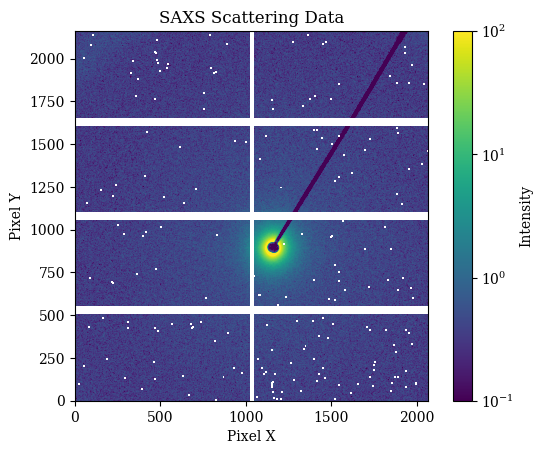

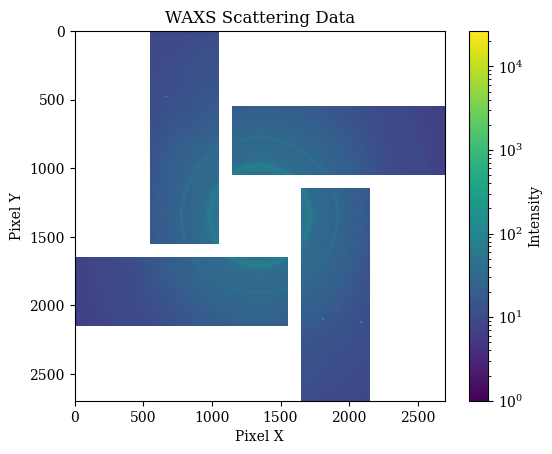

In [4]:

def plot_detector_data(data, scattering_method, ax=None):
    """
    Plots the detector data for either SAXS or WAXS scattering methods.

    Parameters
    ----------
    data : numpy.ndarray
        The data array to plot.
    scattering_method : str
        The scattering method used, either 'SAXS' or 'WAXS'.
    ax : matplotlib.axes.Axes, optional
        Matplotlib axes object on which to plot. If None, uses the current axes (`plt.gca()`).

    Returns
    -------
    im : matplotlib.image.AxesImage
        The image object created.

    Notes
    -----
    - For 'SAXS' (Eiger detector), applies a symmetric logarithmic normalization.
    - For 'WAXS' (Lambda detector), applies a logarithmic normalization.
    - Automatically handles NaN values in the data.
    """
    if ax is None:
        ax = plt.gca()

    # Check for correct input
    scattering_method_upper = scattering_method.upper()
    if scattering_method_upper not in ['SAXS', 'WAXS']:
        raise ValueError("Invalid scattering_method. Must be 'SAXS' or 'WAXS'.")

    if scattering_method_upper == 'SAXS':
        # Plotting parameters for SAXS data
        norm = mcolors.SymLogNorm(linthresh=1e-3, vmin=1e-1, vmax=1e2)
        cmap = 'viridis'
        origin = 'lower'
        title = 'SAXS Scattering Data'
    elif scattering_method_upper == 'WAXS':
        # Plotting parameters for WAXS data
        norm = mcolors.LogNorm()
        cmap = 'viridis'
        origin = 'upper'
        title = 'WAXS Scattering Data'
    else:
        raise ValueError("Invalid detector_type after mapping. This should not happen.")

    im = ax.imshow(
        data,
        norm=norm,
        cmap=cmap,
        origin=origin
    )
    ax.set_title(title)
    ax.set_xlabel('Pixel X')
    ax.set_ylabel('Pixel Y')
    plt.colorbar(im, ax=ax, label='Intensity')

    return im

fig, ax1 = plt.subplots()
plot_detector_data(SAXS_data, scattering_method='SAXS', ax=ax1)
plt.show()

fig, ax2 = plt.subplots()
plot_detector_data(WAXS_data, scattering_method='WAXS', ax=ax2)
plt.show()

# 3 Integrate Data
The data in this form is not directly useful for anything other than displaying the diffraction patterns, it needs to be processed for us to be able to continue the analysis. To understand the logic behind what is done with the data, let us go through some brief scattering theory.

The scattering behaviour of X-rays can be explained by Bragg's law

\begin{equation}
n\lambda = 2dsin(\theta), \tag{1}
\end{equation}

where $n$ is a positive integer, $\lambda$ the wavelength of X-rays, $d$ the so called repeating distance between structures in the sample and $2\theta$ the scattering angle. According to Bragg's law, intensity peaks in the diffraction pattern dirrectly correspond to a repeating unit in the material.

When studying diffraction patterns it is conventient to define a wave vector $\boldsymbol{q}$ as

\begin{equation}
\boldsymbol{q} = \boldsymbol{k}_0 - \boldsymbol{k}_1, \tag{2}
\end{equation}

where $\boldsymbol{k}_0$ is the primary wave vector of incoming X-rays that go through the sample without scattering and $\boldsymbol{k}_1$ the wave vector of scattered X-rays at an angle $2\theta$ from $\boldsymbol{k}_0$. When the primary wave is scattered elastically, the wavelength remain constant, thus the length of $\boldsymbol{k}_1$ must be equal to $\boldsymbol{k}_0$. The magnitude of $\boldsymbol{k}_0$ is determined by its wavelength number $|\boldsymbol{k}_0| = \frac{2\pi}{\lambda}$. We can then calculate the magnitude of the wave vector $\boldsymbol{q}$ (which is the radius from the center of our diffraction pattern) with the help of the law of cosines

\begin{equation}
|\boldsymbol{q}| = |\boldsymbol{k}_0 - \boldsymbol{k}_1| = \sqrt{ \boldsymbol{k}_0^2 + \boldsymbol{k}_1^2 - 2\boldsymbol{k}_0\boldsymbol{k}_1\text{cos}(2\theta) } = \sqrt{ 2(\frac{2\pi}{\lambda})^2 \cdot 2\text{sin}^2(\theta) } = \frac{4\pi\text{sin}(\theta)}{\lambda}, \tag{3}
\end{equation}

where the trigonometric identity $\text{cos}(2\theta) = 1 - 2\text{sin}^2(\theta)$ is used between the third equality.

By combining (1) and (3) we get a relationship between the repeating distance $d$ and $|\boldsymbol{q}|$ (referred to as $q$ from here on out)

\begin{equation}
d = \frac{2\pi}{q} \iff q = \frac{2\pi}{d}, \tag{4}
\end{equation}

where $n = 1$ since we in this case only look at the first occurance of the intensity peak. We see that $q$ is inversely proportional to the repeating distance.

The important thing to draw from the above math excursion is that since we have a direct relationship between $d$ and $q$, it would be nice if we could express our intensity data $I$ in terms of $q$. Since $q$ is the radial component of the diffraction images, it makes sense to convert the original $I(x,y)$ which is in Cartesian coordinates to 2D-polar coordinates $I(q, \phi)$, where $\phi\in[0,2\pi]$ is the azimuthal angle of $q$ ($^{\circ}$).

Luckily, this is done for us automatically for each scan at MAX IV. In addition to the conversion to polar coordinates, this data is also normalized for beam intensity fluctuations and corrected for polarization. The data is availible in the /process/azint/ folder with labels:

    scan-xxxx_lambda_integrated.h5: The transformed data from the WAXS scan.
    scan-xxxx_eiger_integrated.h5: The transformed data from the SAXS scan.


Let us now load the transformed data.

In [5]:
def load_transformed_data(scan_number: int, scattering_method: str):
    """
    Load the transformed data and return a dictionary with the relevant keys.

    Parameters
    ----------
    scan_number : int
        The scan number identifying the specific sample.
    scattering_method : str
        Scattering method used ('SAXS' or 'WAXS').

    Returns
    -------
    data : dict
        A dictionary containing the loaded data.

    Keys in the returned data dictionary:

    **From Integrated (Azimuthally Integrated) File**
    - 'I' : Cake plot from radial integration, shape (image, azimuthal angle, q)
    - 'azi' : Azimuthal bins (degrees)
    - 'q' : q-vector for integration (Å⁻¹)
    - 'mask_file' : File path for mask used in radial integration
    - 'norm' : Weights/norm sum for computing averages for integrated data
    - 'polarization_factor' : Polarization factor used for integration
    - 'poni_file' : File path for PONI file

    **From Raw (Master) File**
    - 'i_t' : Diode data, transmittance for 2D map
    - 'title' : Scan command from the instrument control software
    - 'shape' : Tuple indicating the shape of the scan (rows, columns)
    """
    # Map scattering_method to detector_type
    detector_mapping = {
        'SAXS': 'eiger',
        'WAXS': 'lambda'
    }

    scattering_method_upper = scattering_method.upper()
    if scattering_method_upper in detector_mapping:
        detector_type = detector_mapping[scattering_method_upper]
    else:
        raise ValueError("Invalid scattering method. Must be 'SAXS' or 'WAXS'.")

    # Get the file path to the integrated data file
    file_path = get_file_path(scan_number, scattering_method, raw=False)

    # Set up dictionary
    data = {}
    items = {
        'I': 'entry/data2d/cake',
        'q': 'entry/data1d/q',
        'azi': 'entry/data2d/azi',
        'mask_file': 'entry/azint/input/mask_file',
        'norm': 'entry/data2d/norm',
        'polarization_factor': 'entry/azint/input/polarization_factor',
        'poni_file': 'entry/azint/input/poni',
    }

    # Load data from the transformed file
    with h5py.File(file_path, 'r') as fh:
        for key, name in items.items():
            # We handle the intensity data separately
            if name in fh:
                data[key] = fh[name][()]
            else:
                print(f"Warning: {name} not found in integrated file.")

    # Find all elements of the norm vector that are non-zero, these also correspond to non-zero q values.
    non_zero_q = np.nonzero(np.sum(data['norm'], axis=0))[0]
    
    # Throw away all data that has zero q values.
    data['norm'] = data['norm'][:, non_zero_q]
    data['q'] = data['q'][non_zero_q]
    data['I'] = data['I'][:, :, non_zero_q]

    # Construct the master file path by removing '_integrated' in the filename
    master_file_path = file_path.replace('process/azint', 'raw')
    master_file_path = master_file_path.replace('_%s_integrated' %detector_type, '')
    master_items = {
        'i_t': 'entry/instrument/albaem-e01_ch1/data',
        'title': 'entry/title',
    }

    # Load data from the master (raw) file
    if os.path.isfile(master_file_path):
        with h5py.File(master_file_path, 'r') as fh:
            for key, name in master_items.items():
                if name in fh:
                    data[key] = fh[name][()]
                else:
                    print(f"Warning: {name} not found in master file.")
    else:
        print(f"Master file {master_file_path} not found.")

    # The command used has information on the snake scan performed, we use it.
    data['shape'] = (int((str(data['title']).split(' '))[8])+1, int((str(data['title']).split(' '))[4]))

    return data

# Load the transformed data
scan_number = 35
SAXS_data = load_transformed_data(scan_number, 'SAXS')
WAXS_data = load_transformed_data(scan_number, 'WAXS')

# Access data
I_SAXS = SAXS_data.get('I')
azi_SAXS = SAXS_data.get('azi')
q_SAXS = SAXS_data.get('q')
shape_SAXS = SAXS_data.get('shape')

I_WAXS = WAXS_data.get('I')
azi_WAXS = WAXS_data.get('azi')
q_WAXS = WAXS_data.get('q')
shape_WAXS = WAXS_data.get('shape')

# Display information
print('SAXS data:')
print(f"The shape of the intensity function is {I_SAXS.shape} (number of images, azimuthal angles, q)")
print(f"There are {len(azi_SAXS)} azimuthal angle measurements, ranging from {azi_SAXS[0]} to {azi_SAXS[-1]} degrees.")
print(f"There are {len(q_SAXS)} q measurements, ranging from q = {q_SAXS[0]:.2e} to q = {q_SAXS[-1]:.2e} Å⁻¹.")
print(f"The scan consists of images for {shape_SAXS[0]} rows and {shape_SAXS[1]} columns.")
print('')
print('WAXS data:')
print(f"The shape of the intensity function is {I_WAXS.shape} (number of images, azimuthal angles, q)")
print(f"There are {len(azi_WAXS)} azimuthal angle measurements, ranging from {azi_WAXS[0]} to {azi_WAXS[-1]} degrees.")
print(f"There are {len(q_WAXS)} q measurements, ranging from q = {q_WAXS[0]:.2e} to q = {q_WAXS[-1]:.2e} Å⁻¹.")
print(f"The scan consists of images for {shape_WAXS[0]} rows and {shape_WAXS[1]} columns.")


SAXS data:
The shape of the intensity function is (3050, 180, 1963) (number of images, azimuthal angles, q)
There are 180 azimuthal angle measurements, ranging from 1.0 to 359.0 degrees.
There are 1963 q measurements, ranging from q = 8.38e-03 to q = 4.41e-01 Å⁻¹.
The scan consists of images for 61 rows and 50 columns.

WAXS data:
The shape of the intensity function is (3050, 180, 1380) (number of images, azimuthal angles, q)
There are 180 azimuthal angle measurements, ranging from 1.0 to 359.0 degrees.
There are 1380 q measurements, ranging from q = 1.25e+00 to q = 5.99e+00 Å⁻¹.
The scan consists of images for 61 rows and 50 columns.


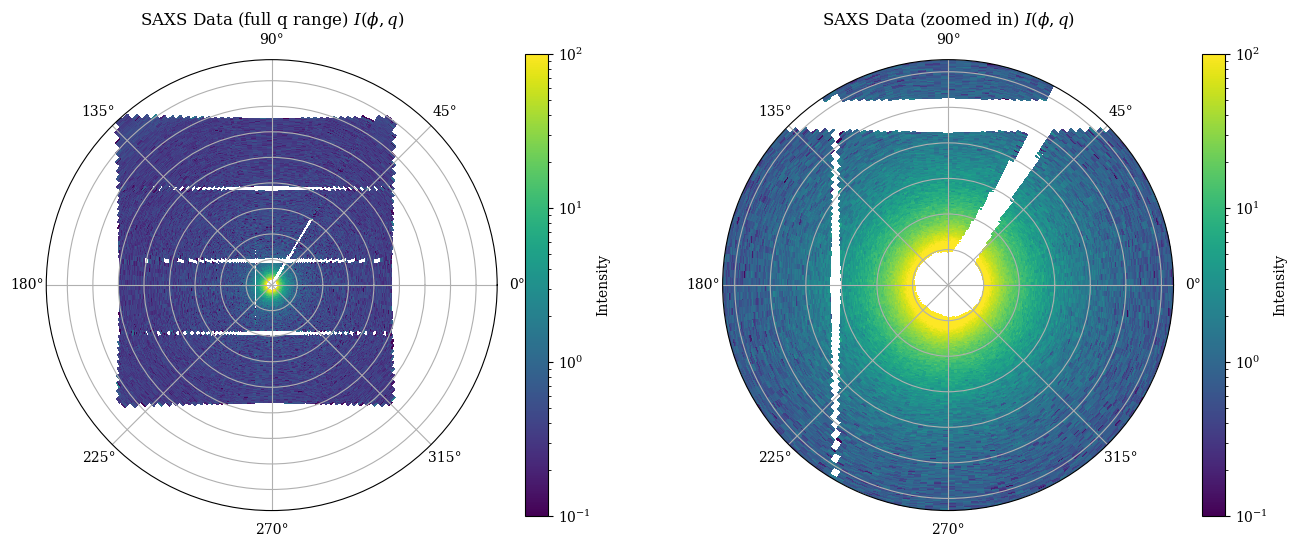

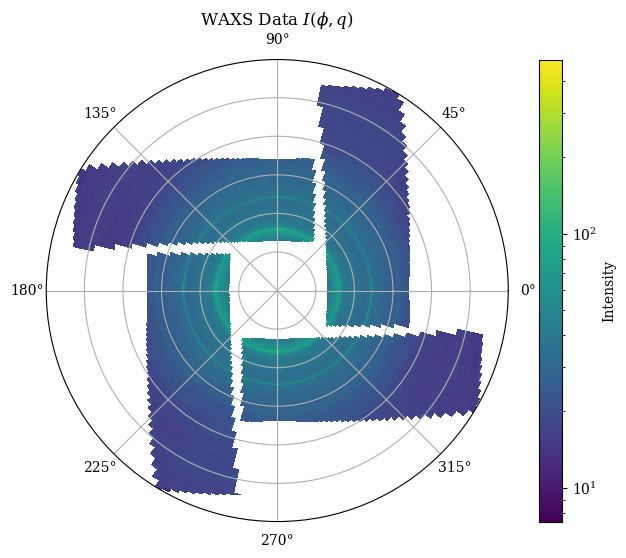

In [6]:

def plot_transformed_data(data, image_number, scattering_method):
    """
    Plots either SAXS or WAXS transformed data.

    Parameters
    ----------
    data : dict
        A dictionary containing the transformed data, typically returned by 'load_transformed_data'.
        Expected keys are 'I', 'azi', and 'q'.
    image : int, optional
        Index of the image to plot if multiple images are present in 'I'. Default is 0.
    scattering_method : str
        Scattering method used (SAXS or WAXS).

    Returns
    -------
    None
    """

    # Extract data from the dictionary
    I = data.get('I')
    azi = data.get('azi')
    q = data.get('q')

    if I is None or azi is None or q is None:
        print("Required data for plotting is missing.")
        return

    # Convert azimuthal angles from degrees to radians
    azi_radians = np.radians(azi)

    # Create meshgrids for azimuthal angles and q values
    azi_grid, q_grid = np.meshgrid(azi_radians, q)

    # Extract specified image from I, transpose to match meshgrid shape
    I_plot = I[image_number, :, :].T
    
    # Convert specified scattering_method to uppercase
    scattering_method_upper = scattering_method.upper()
    
    # Set colormap
    cmap = plt.cm.viridis

    if scattering_method_upper == 'SAXS':
        # Specify logscale
        norm = mcolors.LogNorm( vmin=1e-1, vmax=1e2)
        
        fig = plt.figure(figsize=(16, 6))
        
        # First subplot of intensity data
        ax1 = fig.add_subplot(121, polar=True)
        im = ax1.pcolormesh(azi_grid, q_grid, I_plot, cmap=cmap, norm=norm)
        
        # Customize the plot
        ax1.set_yticklabels([])
        plt.colorbar(im, ax=ax1, label='Intensity')
        ax1.set_title(r'SAXS Data (full q range) $I(\phi, q)$')
        
        # Select data for zoomed-in plot
        max_q = 250
        I_zoom = I_plot[:max_q, :]
        q_zoom = q[:max_q]
        azi_grid_zoom, q_grid_zoom = np.meshgrid(azi_radians, q_zoom)
        
        # Second subplot of intensity data over a narrower q-range
        ax2 = fig.add_subplot(122, polar=True)
        im = ax2.pcolormesh(azi_grid_zoom, q_grid_zoom, I_zoom, cmap=cmap, norm=norm)
        
        # Customize the plot
        ax2.set_yticklabels([])
        plt.colorbar(im, ax=ax2, label='Intensity')
        ax2.set_title(r'SAXS Data (zoomed in) $I(\phi, q)$')
        
    elif scattering_method_upper == 'WAXS':
        # Specify logscale 
        norm = mcolors.LogNorm()
        
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, polar=True)

        # Plot the intensity data
        im = ax.pcolormesh(azi_grid, q_grid, I_plot, cmap=cmap, norm=norm)

        # Customize the plot
        plt.colorbar(im, ax=ax, label='Intensity')
        ax.set_yticklabels([])
        ax.set_title(r'WAXS Data $I(\phi, q)$')
    else:
        raise ValueError("Invalid scattering method.")
    plt.show()

plot_transformed_data(SAXS_data, 500, 'SAXS')    
plot_transformed_data(WAXS_data, 500, 'WAXS')

## 3.1 Azimuthal integration
If we integrate (average) the intensity over some range of $q$-values (radius) for some azimuthal angles $\phi$ the result is intensity dependent on only $q$. We refer to this as *azimuthal integration*. This data representation $I(\phi)$ is useful because it can be analyzed to infer how frequent different $q$-values--which corresponds to repeating distances $d$ (see equation (4) above)--are diffracted in our sample.

We can also compare if there is a difference between differnt directions in the sample, e.g. east, west, north, south direction.

Let's integrate in directions east, west, north, south and compare.


In [37]:
def azimuthal_integration(data, azi_min=0, azi_max=360):
    """
    Integrate (average) the intensity between the specified minimum azimuthal angle and the maximum one
    for all q. Handles azimuthal wrapping for ranges like 340° to 20°.

    Parameters
    ----------
    data : dict
        The data dictionary containing the keys 'I', 'q', 'azi', and 'norm'.
        - 'I' : Intensity data, shape (images, azimuthal angles, q).
        - 'q' : Radial q-vector for the integration (Å⁻¹).
        - 'azi' : Azimuthal angles in degrees (0 to 360).
        - 'norm' : Normalization weights for computing averages.

    azi_min : float, optional
        The minimum azimuthal angle for the integration range in degrees (default is 0°).
    azi_max : float, optional
        The maximum azimuthal angle for the integration range in degrees (default is 360°).

    Returns
    -------
    I_azimuthal_integrated : ndarray
        The intensity integrated over the specified azimuthal range for all q.

        - If `data['I']` has 3 dimensions, the result has shape (images, q).
        - If `data['I']` has 4 dimensions, the result has shape (rows, columns, q).

    Notes
    -----
    - Handles wraparound cases where azi_min > azi_max (e.g., 340° to 20°).
    - Uses safe division to avoid division by zero when normalization weights are zero.
    """
    I = data["I"]
    q = data["q"]
    azi = data["azi"]
    w = data["norm"]  # Weight matrix for the weighted mean

    if azi_min > azi_max:  # Handle wraparound
        # Split into two ranges: [azi_min, 360°] and [0°, azi_max]
        indx_range1 = np.where(azi >= azi_min)[0]
        indx_range2 = np.where(azi < azi_max)[0]
        indx_min = np.concatenate([indx_range1, indx_range2])
    else:
        # Regular case
        indx_min = np.where((azi >= azi_min) & (azi < azi_max))[0]

    # Filter the data to include only the relevant azimuthal angles
    I_azi = I[:, indx_min, :]
    w_azi = w[indx_min, :]

    # Sum of the weights across all considered azi angles
    norm_sum = np.sum(w_azi, axis=0)  

    # Mask norm_sum where it's zero
    norm_sum_safe = np.where(norm_sum == 0, np.nan, norm_sum)  # Replace zeros with NaN

    ndim = len(np.shape(I))  # So that it works on either original data, or reshaped
    if ndim == 3:
        I_times_norm = I_azi * w_azi[None, :, :]  # Weighted measurements
        I_azimuthal_integrated = np.sum(I_times_norm, axis=1) / norm_sum_safe[None, :]
    elif ndim == 4:
        I_times_norm = I_azi * w_azi[None, None, :, :]  # Weighted measurements
        I_azimuthal_integrated = np.sum(I_times_norm, axis=2) / norm_sum_safe[None, None, :]
    else:
        raise ValueError("Incompatible number of dimensions for the intensity")

    # Optionally replace NaN with zeros or another default value
    #I_azimuthal_integrated = np.nan_to_num(I_azimuthal_integrated, nan=0.0)

    return I_azimuthal_integrated


# Define azimuthal slices
slices = {
    'east': (340, 20),    # Wraparound slice from 340° to 20°
    'north': (70, 110),   # From 70° to 110°
    'west': (160, 200),   # From 160° to 200°
    'south': (250, 290),  # From 250° to 290°
    'full': (0, 360)      # Entire range
}
directions = list(slices.keys())
I_SAXS_azi_integrated = {}
I_WAXS_azi_integrated = {}
for direction, (azi_min, azi_max) in slices.items():
    I_SAXS_azi_integrated[direction] = azimuthal_integration(SAXS_data, azi_min=azi_min, azi_max=azi_max)
    I_WAXS_azi_integrated[direction] = azimuthal_integration(WAXS_data, azi_min=azi_min, azi_max=azi_max)
print(f'Azimuthal integration done.')
print(f'dict: I_SAXS_azi_integrated with keys: %s.' %directions)
print(f'dict: I_WAXS_azi_integrated dict with keys: %s.' %directions)

Azimuthal integration done.
I_SAXS_azi_integrated dict with keys: ['east', 'north', 'west', 'south', 'full'].
I_WAXS_azi_integrated dict with keys: ['east', 'north', 'west', 'south', 'full'].


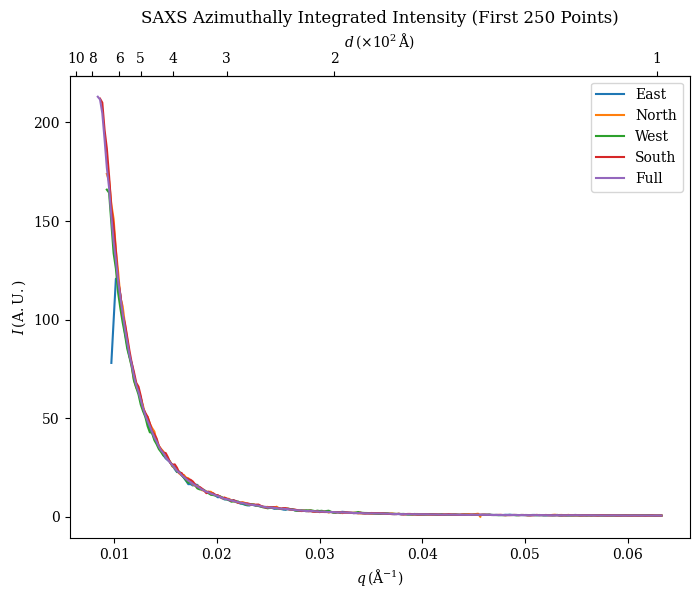

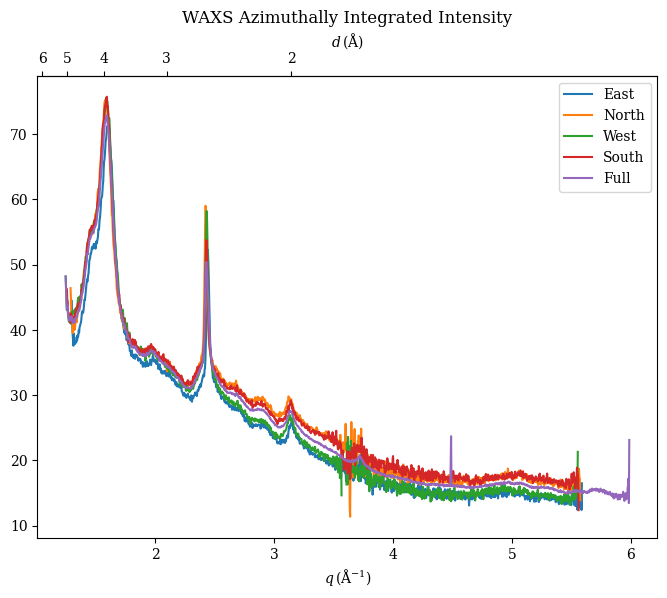

In [46]:
def plot_azimuthal_integrated_data(q_data, I_data, directions, scattering_method, image_number, max_points=250):
    """
    Plot radially integrated intensity for all specified directions for SAXS and WAXS,
    with an additional x-axis for d = 2pi/q.

    Parameters
    ----------
    q_saxs : numpy.ndarray
        q-vector for SAXS data.
    I_saxs : dict
        Dictionary containing radially integrated intensity for SAXS data, keyed by direction.
    q_waxs : numpy.ndarray
        q-vector for WAXS data.
    I_waxs : dict
        Dictionary containing radially integrated intensity for WAXS data, keyed by direction.
    directions : list
        List of directions to plot (e.g., ['east', 'north', 'west', 'south', 'full']).
    max_points : int
        Number of points to plot from the q-vector and corresponding intensity.
    """
    def q_to_d(q):
        """Convert q (Å⁻¹) to d (Å), excluding zero or near-zero values."""
        q_safe = np.clip(q, 1e-6, None)  # Replace q <= 0 with a small positive value
        return 2 * np.pi / q_safe
    
    def d_to_q(d):
        """Convert d (Å) to q (Å⁻¹), excluding zero or near-zero values."""
        d_safe = np.clip(d, 1e-6, None)
        return 2 * np.pi / d_safe

    # Convert specified scattering_method to uppercase
    scattering_method_upper = scattering_method.upper()

    if scattering_method_upper == 'SAXS':
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111)
        for direction in directions:
            ax.plot(
                q_data[:max_points],
                I_data[direction][image_number, :max_points].T,
                label=direction.capitalize()
            )
        
        ax.set_title("SAXS Azimuthally Integrated Intensity (First 250 Points)")
        ax.set_xlabel(r"$q \, (\mathrm{\AA}^{-1})$")
        ax.set_ylabel(r"$I \, (\mathrm{A.U.})$")
        ax.legend()

        # Add secondary x-axis for d
        secax = ax.secondary_xaxis('top', functions = (q_to_d, d_to_q))
        secax.set_xticks([100, 200, 300, 400, 500, 600, 800, 1000])
        secax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x / 100)}"))
        secax.xaxis.offsetText.set_visible(False)                                      # Hide the default offset
        secax.set_xlabel(r"$d \, (\times 10^2 \, \mathrm{\AA})$")
        
    elif scattering_method_upper == 'WAXS':
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111)
        for direction in directions:
            ax.plot(
                q_data,
                I_data[direction][image_number,:].T,
                label=direction.capitalize()
        )
        ax.set_title("WAXS Azimuthally Integrated Intensity")
        ax.set_xlabel(r"$q \, (\mathrm{\AA}^{-1})$")
        ax.legend()

        # Add secondary x-axis for d
        secax = ax.secondary_xaxis('top', functions = (q_to_d, d_to_q))
        secax.set_xlabel(r"$d \, (\mathrm{\AA})$")
        secax.set_xticks([1, 2, 3, 4, 5, 6])

    else:
        raise ValueError("Invalid scattering method.")

    plt.show()

# Example usage
q_SAXS = SAXS_data["q"]
q_WAXS = WAXS_data["q"]

plot_azimuthal_integrated_data(q_SAXS, I_SAXS_azi_integrated, directions, 'SAXS', 500, max_points=250)
plot_azimuthal_integrated_data(q_WAXS, I_WAXS_azi_integrated, directions, 'WAXS', 500, max_points=250)


## 3.2 Radial integration
While from visual inspection you might see some differences above between the different directions, it would be nice to quantify the difference somehow. One way of doing that is to, instead of integrating (averaging) across azimuthal angles $\phi$, we integrate across $q$--for some $phi$ range. We refer to this as radial integration and the result from it is intensity data as a function of $\phi$.

We begin by performing the integration and plotting the result.

In [44]:
def radial_integration(data, q_min, q_max):
    """
    Integrate (average) the intensity between the specified minimum q value and the maximum one
    for all azimuthal angles. The result is referred to as azimuthally integrated data I(azi).
    
    Parameters
    ----------
    data : dict
        The data dictionary containing the keys 'I', 'q', 'azi', and 'norm'.
    q_min : float
        The minimum q value for the integration range.
    q_max : float
        The maximum q value for the integration range.

    Returns
    -------
    I_radial_integrated : ndarray
        The intensity as a function of azimuthal angles (I(azi)).
    """
    I = data["I"]
    q = data["q"]
    azi = data["azi"]
    w = data["norm"]  # Weight matrix for the weighted mean

    # Find indices for the q range
    indx_min = np.where(q >= q_min)[0][0]
    indx_max = np.where(q <= q_max)[0][-1]

    # Filter the data to include only the relevant q range
    I_q = I[..., :, indx_min:indx_max + 1]
    w_q = w[:, indx_min:indx_max + 1]

    # Sum of the weights across all considered q values
    norm_sum = np.sum(w_q, axis=1)

    # Mask norm_sum where it's zero
    norm_sum_safe = np.where(norm_sum == 0, np.nan, norm_sum)  # Replace zeros with NaN

    ndim = len(np.shape(I))  # So that it works on either original data, or reshaped
    if ndim == 3:
        I_times_norm = I_q * w_q[None, :, :]  # Weighted measurements
        I_radial_integrated = np.sum(I_times_norm, axis=2) / norm_sum_safe[None, :]
    elif ndim == 4:
        I_times_norm = I_q * w_q[None, None, :, :]  # Weighted measurements
        I_radial_integrated = np.sum(I_times_norm, axis=3) / norm_sum_safe[None, None, :]
    else:
        raise ValueError("Incompatible number of dimensions for the intensity")

    # Optionally replace NaN with zeros or another default value
    #I_radial_integrated = np.nan_to_num(I_radial_integrated, nan=0.0)

    return I_radial_integrated

# Define q_min and q_max
q_min_SAXS = np.min(SAXS_data["q"])
q_max_SAXS = SAXS_data["q"][49]
q_min_WAXS = np.min(WAXS_data["q"])
q_max_WAXS = WAXS_data["q"][499]

I_SAXS_rad_integrated = radial_integration(SAXS_data, q_min=q_min_SAXS, q_max=q_max_SAXS)
I_WAXS_rad_integrated = radial_integration(WAXS_data, q_min=q_min_WAXS, q_max=q_max_WAXS)

We plot the data to inspect it.

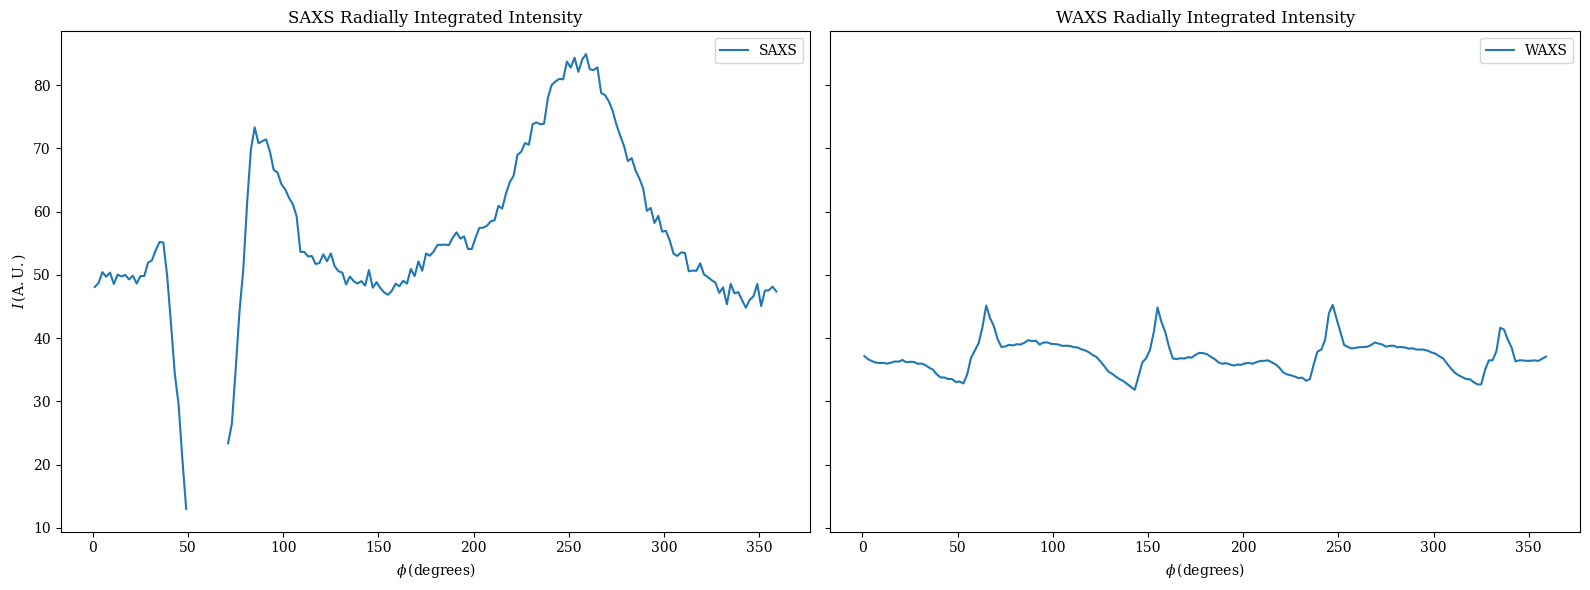

In [47]:
def plot_radially_integrated_data(azi_saxs, I_saxs, azi_waxs, I_waxs, image_number):
    """
    Plot radially integrated intensity as a function of azimuthal angles for SAXS and WAXS data.

    Parameters
    ----------
    azi_saxs : numpy.ndarray
        Azimuthal angles for SAXS data (in degrees).
    I_saxs : numpy.ndarray
        Radially integrated intensity for SAXS data as a function of azimuthal angles.
    azi_waxs : numpy.ndarray
        Azimuthal angles for WAXS data (in degrees).
    I_waxs : numpy.ndarray
        Radially integrated intensity for WAXS data as a function of azimuthal angles.
    """
    fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

    # Plot SAXS data
    axs[0].plot(
        azi_saxs,
        I_saxs[image_number,:].T,
        label="SAXS"
    )
    axs[0].set_title("SAXS Radially Integrated Intensity")
    axs[0].set_xlabel(r"$\phi \, (\mathrm{degrees})$")
    axs[0].set_ylabel(r"$I \, (\mathrm{A.U.})$")
    axs[0].legend()

    # Plot WAXS data
    axs[1].plot(
        azi_waxs,
        I_waxs[image_number,:].T,
        label="WAXS"
    )
    axs[1].set_title("WAXS Radially Integrated Intensity")
    axs[1].set_xlabel(r"$\phi \, (\mathrm{degrees})$")
    axs[1].legend()

    plt.tight_layout()
    plt.show()

azi_saxs = SAXS_data["azi"]
azi_waxs = WAXS_data["azi"]

plot_radially_integrated_data(azi_saxs, I_SAXS_rad_integrated, azi_waxs, I_WAXS_rad_integrated, 500)


For the SAXS data we see a large portion of missing data, this is due to the light absorbing rod that is present in the experiments, which covers a portion of the sample (see visuals of SAXS data in previous section).

If we now compare the different directions by taking the average over sections of azimuthal angles $\phi$. We can use the directions previously defined.

Let us compare:

    - north vs. south
    - east vs. west
    - vertical vs. horizontal

By the ratios:

    - $\alpha_{ns} = \Bar{I}_{north} / \Bar{I}_{south}$
    - $\alpha_{ew} = \Bar{I}_{east} / \Bar{I}_{west}$
    - $\alpha_{vh} = \Bar{I}_{vert} / \Bar{I}_{horz}$

Values close to 1 signify symmetry betwen the compared directions.

In [90]:
ratios = {
    'ns': ('east', 'west'),
    'ew': ('north', 'south'),
    'vh': ('northsouth', 'eastwest'),
}
#for ratio in ratios:
indx_range_saxs = {}
indx_range_waxs = {}
for direction, (azi_min, azi_max) in slices.items():
    if azi_min > azi_max:  # Handle wraparound
        # Split into two ranges: [azi_min, 360°] and [0°, azi_max]
        indx_range1 = np.where(azi_saxs >= azi_min)[0]
        indx_range2 = np.where(azi_saxs < azi_max)[0]
        indx_range_saxs[direction] = np.concatenate([indx_range1, indx_range2])
    else:
        # Regular case
        indx_range_saxs[direction] = np.where((azi_saxs >= azi_min) & (azi_saxs < azi_max))[0]

symmetry_ratios_saxs = {}
for ratio, (dir1, dir2) in ratios.items():
    if ratio == 'vh':
        symmetry_ratios_saxs[ratio] = ( (I_SAXS_rad_integrated[500,indx_range_saxs['east']].mean(0) + I_SAXS_rad_integrated[500,indx_range_saxs['west']].mean(0))
                                        / (I_SAXS_rad_integrated[500,indx_range_saxs['north']].mean(0) + I_SAXS_rad_integrated[500,indx_range_saxs['south']].mean(0)) )
    else:
        symmetry_ratios_saxs[ratio] = I_SAXS_rad_integrated[500,indx_range_saxs[dir1]].mean(0) / I_SAXS_rad_integrated[500,indx_range_saxs[dir2]].mean(0)

for direction, (azi_min, azi_max) in slices.items():
    if azi_min > azi_max:  # Handle wraparound
        # Split into two ranges: [azi_min, 360°] and [0°, azi_max]
        indx_range1 = np.where(azi_waxs >= azi_min)[0]
        indx_range2 = np.where(azi_waxs < azi_max)[0]
        indx_range_waxs[direction] = np.concatenate([indx_range1, indx_range2])
    else:
        # Regular case
        indx_range_waxs[direction] = np.where((azi_saxs >= azi_min) & (azi_waxs < azi_max))[0]

symmetry_ratios_waxs = {}
for ratio, (dir1, dir2) in ratios.items():
    if ratio == 'vh':
        symmetry_ratios_waxs[ratio] = ( (I_WAXS_rad_integrated[500,indx_range_waxs['east']].mean(0) + I_WAXS_rad_integrated[500,indx_range_waxs['west']].mean(0))
                                        / (I_WAXS_rad_integrated[500,indx_range_waxs['north']].mean(0) + I_WAXS_rad_integrated[500,indx_range_waxs['south']].mean(0)) )
    else:
        symmetry_ratios_waxs[ratio] = I_WAXS_rad_integrated[500,indx_range_waxs[dir1]].mean(0) / I_WAXS_rad_integrated[500,indx_range_waxs[dir2]].mean(0)

print('Symmetry ratios for SAXS data:')
print('north-south symmetry ratio = %f' %symmetry_ratios_saxs['ns'])
print('east-west symmetry ratio = %f' %symmetry_ratios_saxs['ew'])
print('vertical-horizontal symmetry ratio = %f' %symmetry_ratios_saxs['vh'])


dict_keys(['ns', 'ew', 'vh'])
Symmetry ratios:
north-south symmetry ratio = 0.907180
east-west symmetry ratio = 0.763744
vertical-horizontal symmetry ratio = 0.752763


# 4 Curve fitting
To ease continued processing and analysis and remove noisy data we employ some curvefitting techniques. We have one version using fourier series and another with gaussian functions.

## 4.1 Removing background noise
In the experiment there is a plastic film covering both sides of the sample. The X-ray passes through this and although the sample is in a vaccum, there might still be some air present. The X-rays can scatter on both the plastic and air which will interfere with the resulting diffraction pattern. We remove this background noise by finding all images corresponding to the plastic film, taking the average total intensity across all those images, and subtracting that value from all intensity data.

In [15]:
def load_azi_data(scan_number: int, scattering_method: str, background_threshold=3):
    """
    Load the transformed data and return a dictionary with the relevant keys.

    Parameters
    ----------
    scan_number : int
        The scan number identifying the specific sample.
    scattering_method : str
        Scattering method used ('SAXS' or 'WAXS').

    Returns
    -------
    data : dict
        A dictionary containing the loaded data.

    Keys in the returned data dictionary:

    **From Integrated (Azimuthally Integrated) File**
    - 'I' : Cake plot from radial integration, shape (image, azimuthal angle, q)
    - 'azi' : Azimuthal bins (degrees)
    - 'q' : q-vector for integration (Å⁻¹)
    - 'mask_file' : File path for mask used in radial integration
    - 'norm' : Weights/norm sum for computing averages for integrated data
    - 'polarization_factor' : Polarization factor used for integration
    - 'poni_file' : File path for PONI file

    **From Raw (Master) File**
    - 'i_t' : Diode data, transmittance for 2D map
    - 'title' : Scan command from the instrument control software
    - 'shape' : Tuple indicating the shape of the scan (rows, columns)
    """
    # Map scattering_method to detector_type
    detector_mapping = {
        'SAXS': 'eiger',
        'WAXS': 'lambda'
    }

    scattering_method_upper = scattering_method.upper()
    if scattering_method_upper in detector_mapping:
        detector_type = detector_mapping[scattering_method_upper]
    else:
        raise ValueError("Invalid scattering method. Must be 'SAXS' or 'WAXS'.")

    # Get the file path to the integrated data file
    file_path = get_file_path(scan_number, scattering_method, raw=False)

    # Set up dictionary
    data = {}
    items = {
        'I': 'entry/data2d/cake',
        'q': 'entry/data1d/q',
        'azi': 'entry/data2d/azi',
        'mask_file': 'entry/azint/input/mask_file',
        'norm': 'entry/data2d/norm',
        'polarization_factor': 'entry/azint/input/polarization_factor',
        'poni_file': 'entry/azint/input/poni',
    }

    # Load data from the transformed file
    with h5py.File(file_path, 'r') as fh:
        for key, name in items.items():
            # We handle the intensity data separately
            if name in fh:
                data[key] = fh[name][()]
            else:
                print(f"Warning: {name} not found in integrated file.")

    # Find all elements of the norm vector that are non-zero, these also correspond to non-zero q values.
    non_zero_q = np.nonzero(np.sum(data['norm'], axis=0))[0]
    
    # Throw away all data that has zero q values.
    data['norm'] = data['norm'][:, non_zero_q]
    data['q'] = data['q'][non_zero_q]
    data['I'] = data['I'][:, :, non_zero_q]

    # Perform the azimuthal integration
    data['I'] = np.sum(data['I'] * data['norm'][...], axis=1) / np.sum(data['norm'], axis=0)[...]
    
    # Construct the master file path by removing '_integrated' in the filename
    master_file_path = file_path.replace('process/azint', 'raw')
    master_file_path = master_file_path.replace('_%s_integrated' %detector_type, '')
    master_items = {
        'i_t': 'entry/instrument/albaem-e01_ch1/data',
        'title': 'entry/title',
    }

    # Load data from the master (raw) file
    if os.path.isfile(master_file_path):
        with h5py.File(master_file_path, 'r') as fh:
            for key, name in master_items.items():
                if name in fh:
                    data[key] = fh[name][()]
                else:
                    print(f"Warning: {name} not found in master file.")
    else:
        print(f"Master file {master_file_path} not found.")

    # The command used has information on the snake scan performed, we use it.
    shape = (int((str(data['title']).split(' '))[8])+1, int((str(data['title']).split(' '))[4]))
    data['shape'] = shape

    # Now we find the indices of the pixels that only contain the background plastic film. As a first step we calculate
    # the mean of the middle row of pixels which we know are not a background row.
    num_rows = shape[0]
    num_cols = shape[1]
    middle_row_first_col = int(shape[0] / 2) * num_cols
    middle_row_mean = np.mean(data['I'][middle_row_first_col:middle_row_first_col+num_cols, :], axis=(0, 1))

    # Now we iterate each row and if the row's mean differ from the middle row by more than the threshold value it is
    # considered a background row.
    background_pixels = np.empty(0, dtype=np.int8)
    background_mean = 0
    number_of_background_rows = 0
    for row in range(num_rows):
        row_mean = np.mean(data['I'][row*num_cols:row*num_cols+num_cols, :], axis=(0, 1))
        if np.abs(middle_row_mean - row_mean) > background_threshold:
            background_pixels = np.append(background_pixels, np.array([i + (row * num_cols) for i in range(num_cols)]), axis=0)
            number_of_background_rows += 1
            background_mean += row_mean
    data['background_pixels'] = background_pixels
    data['background_mean'] = background_mean / number_of_background_rows

    return data

scan_number = 35
WAXS_azi_data = load_azi_data(scan_number, 'WAXS')

# Subtract the mean background noise from the intensity data
WAXS_azi_data['I'] = WAXS_azi_data['I'] - WAXS_azi_data['background_mean']

The rest of this chapter we will examine three pixels. However, the code is written such that any number of pixels can be entered for the analysis. Define the pixels that you wish to examine. The count starts at 0 in the upper left corner and then follows to the right following the snake scan.

The plot of the sample images show which pixels are selected. 

### 4.1.1 Plot data without background noise



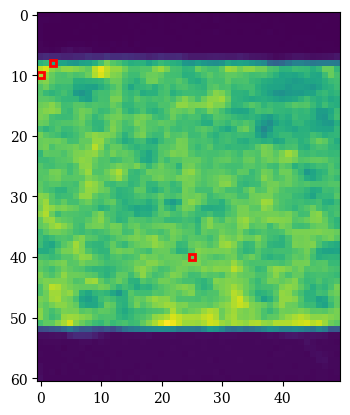

In [16]:
pixels = [402, 500, 2025]

I_flipped = np.reshape(np.mean(WAXS_azi_data['I'], axis=1), (WAXS_azi_data['shape'][0], WAXS_azi_data['shape'][1]))
I_flipped[1::2,:] = I_flipped[1::2,::-1]
pixels_flipped = np.zeros(WAXS_azi_data['I'].shape[0])
pixels_flipped[pixels] = 1
pixels_flipped = np.reshape(pixels_flipped, (WAXS_azi_data['shape'][0], WAXS_azi_data['shape'][1]))
pixels_flipped[1::2,:] = pixels_flipped[1::2,::-1]

plt.imshow(I_flipped)
ax = plt.gca()

pixels_to_frame = pixels_flipped.nonzero()
for i in range(len(pixels_to_frame[0])):
    y = pixels_to_frame[0][i]
    x = pixels_to_frame[1][i]
    rect = plt.Rectangle((x-.5, y-.5), 1,1, fill=False, color='red', linewidth=2)
    ax.add_patch(rect)
    
plt.show()

Now lets inspect the intensity plots for each of the background corrected pixels.

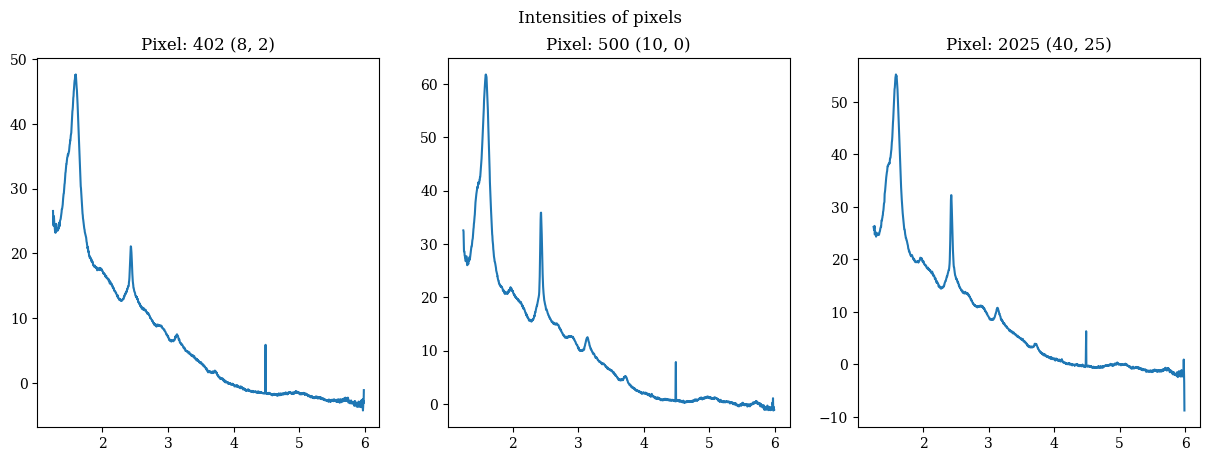

In [19]:
fig, ax = plt.subplots(1, len(pixels))
fig.suptitle('Intensities of pixels')
fig.set_figwidth(15)

for i, pixel in enumerate(pixels):
    ax[i].plot(WAXS_azi_data['q'], WAXS_azi_data['I'][pixel])
    ax[i].plot(I_data[direction][image_number, :max_points]
    ax[i].set_title('Pixel: {} ({}, {})'.format(pixel, pixels_to_frame[0][i], pixels_to_frame[1][i]))

## 4.3 Fit nosie free data (Fourier)
Fourier series
In the next step we will try to find the peaks of each pixel's plot.

To find the peaks we first filter the intensity data to smoothen the curve to easier find the "real" peaks and not just noise. For this we use the `scipy.signal` library method `medfilt`. The parameter `kernel_size` specifies how much the data should be smoothened and must be set by the user. (I saw that Edvin used another method for this, I don't know which one is best.)

The next step is to find the actual peaks. We continue to use the `scipy.signal` library but with the method `find_peaks`. This method takes a bunch of different optional parameters to tune the search. I have just tried some randomly and found that these two seems to work reasonable well.

This step is to be able to tweak the parameters. When we are happy with the peaks found for the pixels we will move on to examine the full sample. 


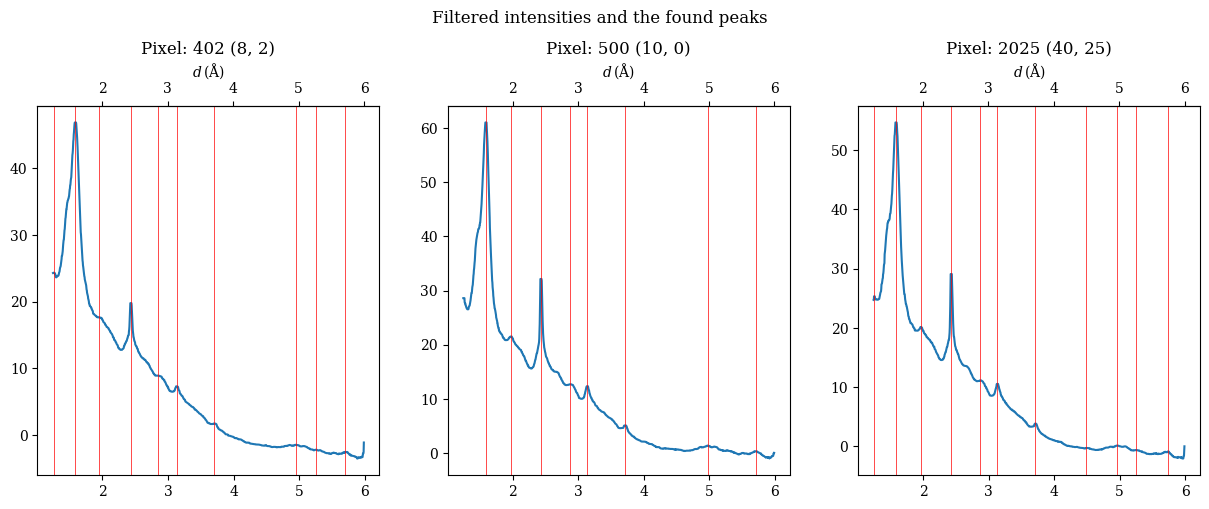

In [22]:
kernel_size = 11
I_filtered = []
for pixel in pixels:
    I_filtered.append(signal.medfilt(WAXS_azi_data['I'][pixel], kernel_size))

distance = 60
width = 4
peak_indices = []
for intensity in I_filtered:
    peak_indices.append(signal.find_peaks(intensity, distance=distance, width=width)[0])

fig, ax = plt.subplots(1, len(pixels))
fig.suptitle('Filtered intensities and the found peaks', y = 1.08)
fig.set_figwidth(15)

for i in range(len(pixels)):
    secax = ax[i].secondary_xaxis('top', functions = (lambda x: 2 * np.pi / x, lambda x: x / (2 * np.pi)))
    secax.set_xlabel(r"$d \, (\mathrm{\AA})$")
    ax[i].plot(WAXS_azi_data['q'], I_filtered[i])
    ax[i].set_title('Pixel: {} ({}, {})'.format(pixels[i], pixels_to_frame[0][i], pixels_to_frame[1][i]))

    for xc in peak_indices[i]:
        ax[i].axvline(x = WAXS_azi_data['q'][xc], ymin = 0, ymax = 1, c ='r', lw=0.5)

Now that we have found parameters that seem to find the peaks we are interested in for a few samples we will apply it to the whole sample. This will give us some idea of how the intensity plot shape is varied across the sample. If the number of peaks found is consistent we should have more confidence to use the sample average when analyzing the intensity peaks.

In this section we create a dictionary `number_of_peaks` on the form `{int, array[int]}` where the key are the number of peaks found and the corresponding value an array stores the image indices. This allows for further inspection of pixels that diverge from the rest of the sample.

Note that we only calculate the number of peaks of pixels that are not in the background.

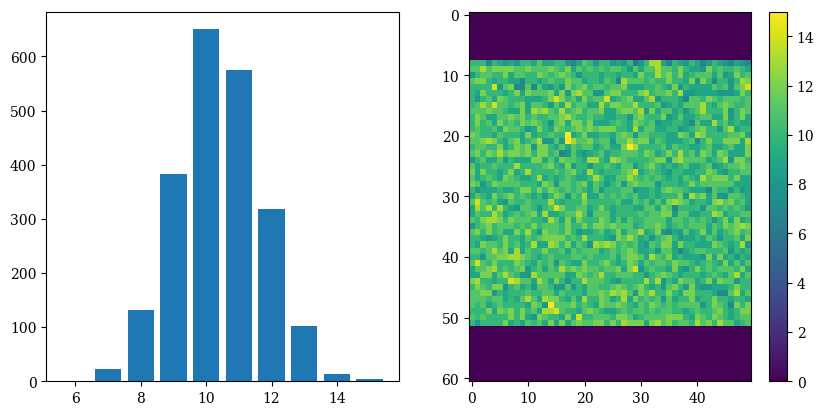

In [23]:
num_peaks = dict()
peaks_found = np.zeros(WAXS_azi_data['I'].shape[0])
for i in range(WAXS_azi_data['I'].shape[0]):
    if i in WAXS_azi_data['background_pixels']:
        continue
    else:
        number_peaks_found = len(signal.find_peaks(signal.medfilt(WAXS_azi_data['I'][i], kernel_size), distance=distance, width=width)[0])
        pixel_indices = num_peaks.get(number_peaks_found, [])
        pixel_indices.append(i)
        num_peaks[number_peaks_found] = pixel_indices
        peaks_found[i] = number_peaks_found

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(10)

bar_plot = [len(i) for i in num_peaks.values()]
ax1.bar(num_peaks.keys(), bar_plot)

peaks_found_flipped = np.reshape(peaks_found, (WAXS_azi_data['shape'][0], WAXS_azi_data['shape'][1]))
peaks_found_flipped[1::2,:] = peaks_found_flipped[1::2,::-1]

image = ax2.imshow(peaks_found_flipped, interpolation='None', aspect='auto')
plt.colorbar(image, ax=ax2)

Now that we see that the shape of the intensity plots seems to be consistent over the whole sample we will calculate the sample average for all rows except the background rows and find the $q$ indices of the peaks.

Peaks: [ 100  210  344  473  550  719  866 1083 1297]


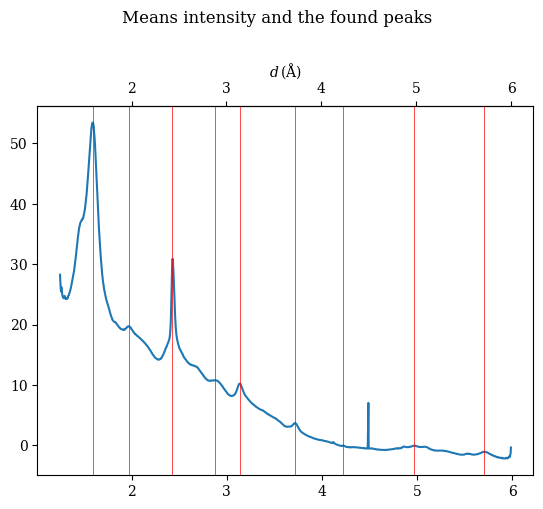

In [24]:
mean_intensity = np.mean(np.delete(WAXS_azi_data['I'], WAXS_azi_data['background_pixels'], axis=0), axis=0 )
peak_indices = signal.find_peaks(mean_intensity, distance=distance, width=width)[0]
print("Peaks: {}".format(peak_indices))

plt.plot(WAXS_azi_data['q'], mean_intensity)
plt.suptitle('Means intensity and the found peaks', y = 1.08)
ax = plt.gca()
secax = ax.secondary_xaxis('top', functions = (lambda x: 2 * np.pi / x, lambda x: x / (2 * np.pi)))
secax.set_xlabel(r"$d \, (\mathrm{\AA})$")

for xc in peak_indices:
    ax.axvline(x = WAXS_azi_data['q'][xc], ymin = 0, ymax = 1, c ='r', lw=0.5)

In this section we will briefly apply some basic signal processing techniques to the intensity data.

We start by applying a Fourier transform to the mean signal acquired from the previous section. We use the library `scipy.fft` for the Fourier transform methods. The method `rfft` computes a 1-D Fourier transform of a real valued array.

The method `rfftfreq` is used to calculate sample frequencies which allows us to plot the transformed signal. 

Text(0.5, 0.98, 'Frequency Spectrum')

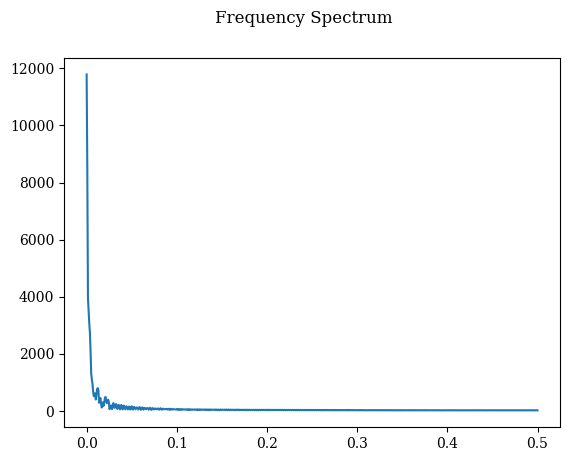

In [27]:
f_hat_dft = fft.rfft(mean_intensity)

frequencies = np.fft.rfftfreq(WAXS_azi_data['q'].size)

plt.plot(frequencies, np.abs(f_hat_dft))
plt.suptitle('Frequency Spectrum')

We see that the largest amplitudes are for the low frequencies which indicates that the signal can be expressed with only a few frequencies.

Lets invert the transform with all data points and for some lower rank.

Text(0, 0.5, 'I (A.U)')

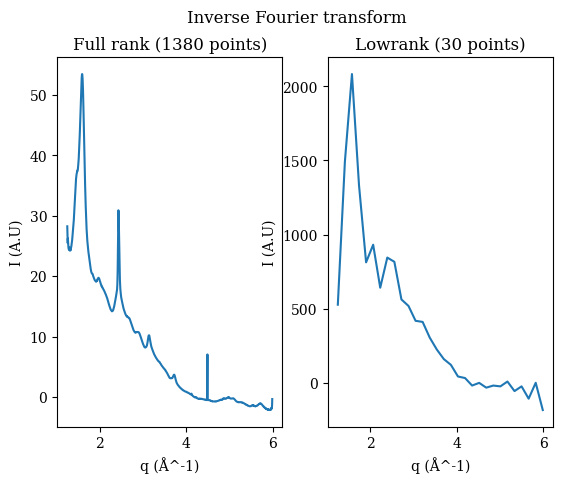

In [28]:
f_dft = fft.irfft(f_hat_dft)

low_rank = 30
f_dft_low_rank = fft.irfft(f_hat_dft, low_rank)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Inverse Fourier transform')

ax1.plot(np.linspace(np.min(WAXS_azi_data['q']), np.max(WAXS_azi_data['q']), f_dft.size), f_dft)
ax1.set_title('Full rank ({} points)'.format(f_dft.size))
ax1.set_xlabel("q (Å^-1)")
ax1.set_ylabel("I (A.U)")

ax2.plot(np.linspace(np.min(WAXS_azi_data['q']), np.max(WAXS_azi_data['q']), f_dft_low_rank.size), f_dft_low_rank)
ax2.set_title('Lowrank ({} points)'.format(f_dft_low_rank.size))
ax2.set_xlabel("q (Å^-1)")
ax2.set_ylabel("I (A.U)")

## 4.4 Fit nosie free data (Gaussian)


(3050, 1380)


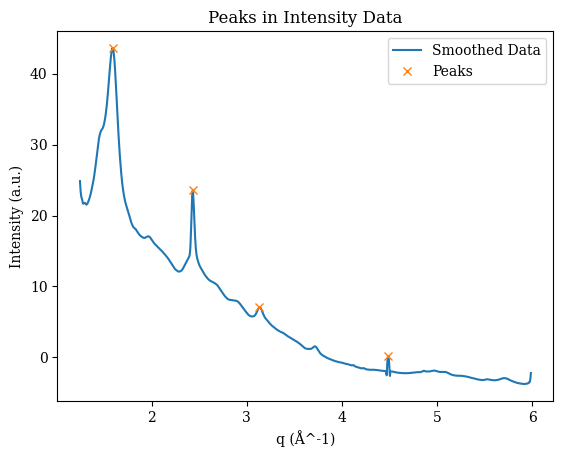

In [29]:
# Compute the y-data
I_waxs_azi = WAXS_azi_data['I']
q_waxs = WAXS_azi_data['q']
print(np.shape(I_waxs_azi))

y_data = np.mean(I_waxs_azi, axis=0)


# Smooth the data to reduce noise
smoothed_y = savgol_filter(y_data, window_length=11, polyorder=3)

# Find peaks
peaks, properties = find_peaks(smoothed_y, prominence=1, width=5)

# Plot the results
plt.plot(q_waxs, smoothed_y, label="Smoothed Data")
plt.plot(q_waxs[peaks], smoothed_y[peaks], "x", label="Peaks")
plt.xlabel("q (Å^-1)")
plt.ylabel("Intensity (a.u.)")
plt.title("Peaks in Intensity Data")
plt.legend()
plt.show()

In [30]:
# Check for NaN or Inf values in y_data
nan_indices = np.isnan(y_data)
inf_indices = np.isinf(y_data)

print("NaN indices:", np.where(nan_indices)[0])
print("Inf indices:", np.where(inf_indices)[0])

# Remove NaN or Inf values
valid_indices = ~(nan_indices | inf_indices)
clean_q = q_waxs[valid_indices]
clean_y = y_data[valid_indices]

NaN indices: []
Inf indices: []


Number of Peaks to Fit: 9


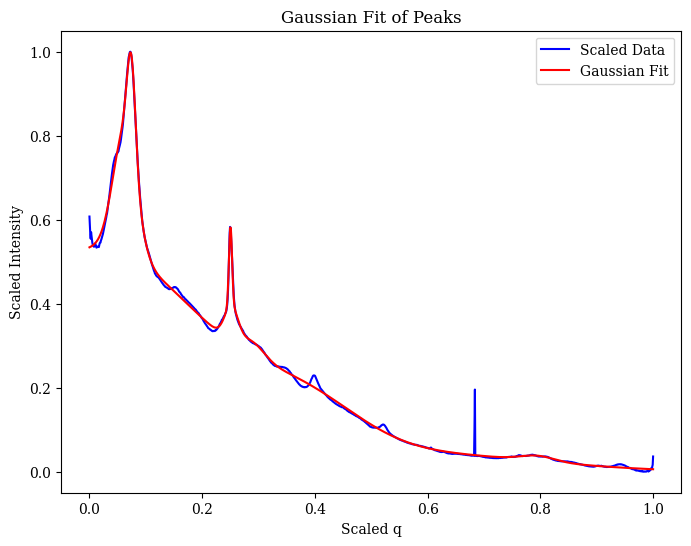

Fitted Parameters (Scaled): [0.0044247  0.07433757 0.00749876 0.01505625 0.06263313 0.02067661
 0.26674476 0.01302396 0.2        0.00180444 0.28829596 0.02204594
 0.00129387 0.25026578 0.00278351 0.01933025 0.61320635 0.2
 0.00231105 0.25167284 0.01164078 0.00093531 0.79483828 0.02993666
 0.02471585 0.38624281 0.10135661]


In [31]:
# Scale input data
clean_q_scaled = (clean_q - np.min(clean_q)) / (np.max(clean_q) - np.min(clean_q))
clean_y_scaled = (clean_y - np.min(clean_y)) / (np.max(clean_y) - np.min(clean_y))

# Find peaks directly in the cleaned data
peak_indices, properties = find_peaks(clean_y_scaled, prominence=0.001, width=5)  # Adjust prominence as needed
sorted_indices = np.argsort(properties["prominences"])[::-1]  # Sort peaks by decreasing prominence

# Number of peaks to fit
max_peaks_to_fit = 10  # Maximum number of peaks to fit, gaussian fit cannot handle too many
num_peaks_to_fit = min(len(peak_indices), max_peaks_to_fit)  # Use at most max_peaks_to_fit peaks
print(f"Number of Peaks to Fit: {num_peaks_to_fit}")

# Sort peaks by prominence descending and select the top ones
sorted_indices = np.argsort(properties["prominences"])[::-1]  # Sort peaks by prominence descending
selected_peaks = peak_indices[sorted_indices[:num_peaks_to_fit]]
selected_prominences = properties["prominences"][sorted_indices[:num_peaks_to_fit]]
selected_widths = properties["widths"][sorted_indices[:num_peaks_to_fit]]

# Construct initial guesses
initial_guess = []
for i in range(num_peaks_to_fit):
    A = selected_prominences[i]  # Use prominence as an estimate for amplitude
    mu = clean_q_scaled[selected_peaks[i]]  # Peak position
    sigma = selected_widths[i] / (2.355 * (clean_q_scaled[1] - clean_q_scaled[0]))  # Convert FWHM to sigma
    initial_guess.extend([A, mu, sigma])

# Define the Gaussian model using scipy.stats.norm
def multi_gaussian(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        A, mu, sigma = params[i:i+3]
        y += A * norm.pdf(x, loc=mu, scale=sigma)  # Using scipy's built-in norm.pdf
    return y

# Define bounds
lower_bounds = [0, 0, 0] * num_peaks_to_fit  # Amplitude >= 0, position >= 0, width >= 0
upper_bounds = [2 * max(clean_y_scaled), 1.0, 0.2] * num_peaks_to_fit  # Adjust upper bounds as necessary

# Ensure initial guess is within bounds
initial_guess = np.clip(initial_guess, lower_bounds, upper_bounds)

# Fit the Gaussian model to the data
try:
    popt, _ = curve_fit(
        multi_gaussian, clean_q_scaled, clean_y_scaled,
        p0=initial_guess, bounds=(lower_bounds, upper_bounds), maxfev=1000
    )
except RuntimeError as e:
    print("Fit failed:", e)
    popt = initial_guess  # Use initial guess if fit fails

# Plot the result
plt.figure(figsize=(8, 6))
plt.plot(clean_q_scaled, clean_y_scaled, label="Scaled Data", color='blue')
plt.plot(clean_q_scaled, multi_gaussian(clean_q_scaled, *popt), label="Gaussian Fit", color='red')
plt.xlabel("Scaled q")
plt.ylabel("Scaled Intensity")
plt.legend()
plt.title("Gaussian Fit of Peaks")
plt.show()

print("Fitted Parameters (Scaled):", popt)